In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [3]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Setup the train and test directories
train_dir = "drive/MyDrive/Colab Notebooks/Lesson18/dataset/train/"
test_dir = "drive/MyDrive/Colab Notebooks/Lesson18/dataset/test/"

In [5]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

In [6]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='categorical',
                                                                            shuffle=True) # Shuffle data (default)

Found 4500 images belonging to 3 classes.


In [7]:
# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 900 images belonging to 3 classes.


In [9]:
model = tf.keras.models.Sequential([Conv2D(filters=32, 
                                           kernel_size=3,
                                           activation="relu", 
                                           input_shape=(224, 224, 3)),
                                    Conv2D(64, 3, activation="relu"),
                                    MaxPool2D(2),
                                    Conv2D(128, 3, activation="relu"),
                                    MaxPool2D(2),
                                    Conv2D(256, 3, activation="relu"),
                                    MaxPool2D(2),
                                    Conv2D(512, 3, activation="relu"),
                                    MaxPool2D(2),
                                    Flatten(),
                                    Dropout(0.7),
                                    Dense(2048, activation = 'relu'),
                                    Dense(3, activation="softmax")])

In [10]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [11]:
# Check out the layers in our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 256)       2

In [13]:
# Fit the model
with tf.device('/device:GPU:0'):
  history = model.fit(train_data_augmented_shuffled,
                    epochs=32,
                    steps_per_epoch=len(train_data_augmented_shuffled),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/32
141/141 [==============================] - 1355s 10s/step - loss: 1.0313 - accuracy: 0.4500 - val_loss: 0.8445 - val_accuracy: 0.6556
Epoch 2/32
141/141 [==============================] - 73s 515ms/step - loss: 0.8162 - accuracy: 0.6564 - val_loss: 0.6047 - val_accuracy: 0.7644
Epoch 3/32
141/141 [==============================] - 72s 512ms/step - loss: 0.7530 - accuracy: 0.6953 - val_loss: 0.5743 - val_accuracy: 0.7911
Epoch 4/32
141/141 [==============================] - 72s 508ms/step - loss: 0.7195 - accuracy: 0.7104 - val_loss: 0.5549 - val_accuracy: 0.7778
Epoch 5/32
141/141 [==============================] - 72s 508ms/step - loss: 0.6724 - accuracy: 0.7284 - val_loss: 0.4961 - val_accuracy: 0.8089
Epoch 6/32
141/141 [==============================] - 71s 504ms/step - loss: 0.6649 - accuracy: 0.7382 - val_loss: 0.5130 - val_accuracy: 0.8233
Epoch 7/32
141/141 [==============================] - 71s 505ms/step - loss: 0.6194 - accuracy: 0.7551 - val_loss: 0.5008 - val_ac

In [14]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

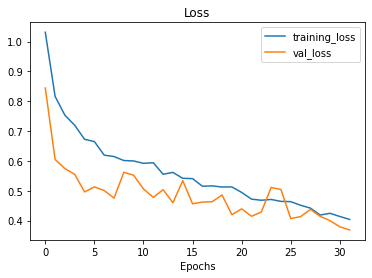

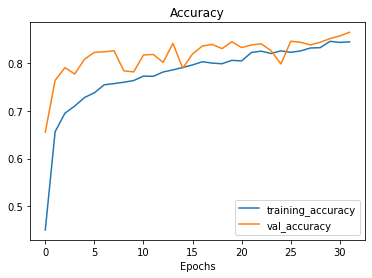

In [15]:
# Check out the loss curves of model
plot_loss_curves(history)

In [16]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels
    # but sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [82]:
def pred_and_plot(model, filename, class_names):
      """
      Imports an image located at filename, makes a prediction on it with
      a trained model and plots the image with the predicted class as the title.
      """
      # Import the target image and preprocess it
      img = load_and_prep_image(filename)

      # Make a prediction
      pred = model.predict(tf.expand_dims(img, axis=0))

      # Get the predicted class
      pred_class = class_names[pred.argmax()]

      # Plot the image and predicted class
      plt.imshow(img)
      plt.title(f"Prediction: {pred_class}")
      plt.show()

In [85]:
class_names = ["chicken", "sheep",'squirrel']

In [19]:
!wget https://images.ctfassets.net/ww1ie0z745y7/44ddTTKchBQvSTOb6crtAi/27eeaddc63e367107a2a7b28ec964dce/chicken-antibiotics-the-humane-league.jpg
!wget https://st.depositphotos.com/1373322/2535/i/450/depositphotos_25354335-stock-photo-beautiful-purebred-brown-chicken-isolated.jpg?forcejpeg=true
!wget https://static.scientificamerican.com/sciam/cache/file/EE55973C-F3FD-44D0-9740ED769F6D195C_source.jpg

--2022-05-01 09:48:03--  https://images.ctfassets.net/ww1ie0z745y7/44ddTTKchBQvSTOb6crtAi/27eeaddc63e367107a2a7b28ec964dce/chicken-antibiotics-the-humane-league.jpg
Resolving images.ctfassets.net (images.ctfassets.net)... 54.192.87.21, 54.192.87.83, 54.192.87.69, ...
Connecting to images.ctfassets.net (images.ctfassets.net)|54.192.87.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2109041 (2.0M) [image/jpeg]
Saving to: ‘chicken-antibiotics-the-humane-league.jpg’

chicken-antibiotics 100%[===================>]   2.01M  13.2MB/s    in 0.2s    

2022-05-01 09:48:03 (13.2 MB/s) - ‘chicken-antibiotics-the-humane-league.jpg’ saved [2109041/2109041]

--2022-05-01 09:48:03--  https://st.depositphotos.com/1373322/2535/i/450/depositphotos_25354335-stock-photo-beautiful-purebred-brown-chicken-isolated.jpg?forcejpeg=true
Resolving st.depositphotos.com (st.depositphotos.com)... 23.51.72.19
Connecting to st.depositphotos.com (st.depositphotos.com)|23.51.72.19|:443... con

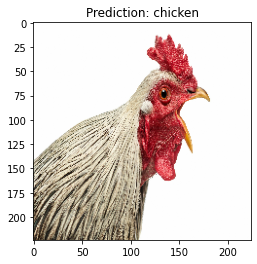

In [86]:
pred_and_plot(model,'/content/EE55973C-F3FD-44D0-9740ED769F6D195C_source.jpg',class_names)

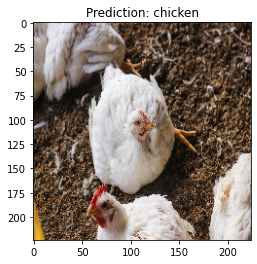

In [87]:
pred_and_plot(model,'/content/chicken-antibiotics-the-humane-league.jpg',class_names)

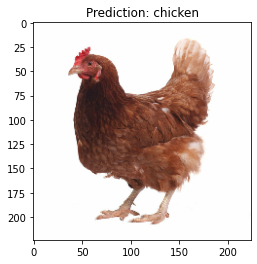

In [88]:
pred_and_plot(model,'/content/depositphotos_25354335-stock-photo-beautiful-purebred-brown-chicken-isolated.jpg?forcejpeg=true',class_names)

In [45]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Cotswold_Sheep_%28cropped%29.JPG/1200px-Cotswold_Sheep_%28cropped%29.JPG

--2022-05-01 09:57:40--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Cotswold_Sheep_%28cropped%29.JPG/1200px-Cotswold_Sheep_%28cropped%29.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 421929 (412K) [image/jpeg]
Saving to: ‘1200px-Cotswold_Sheep_(cropped).JPG’

1200px-Cotswold_She 100%[===================>] 412.04K  --.-KB/s    in 0.02s   

2022-05-01 09:57:40 (21.1 MB/s) - ‘1200px-Cotswold_Sheep_(cropped).JPG’ saved [421929/421929]



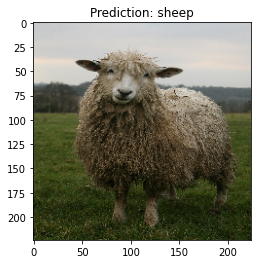

In [89]:
pred_and_plot(model,'/content/1200px-Cotswold_Sheep_(cropped).JPG',class_names)

In [47]:
!wget https://www.aces.edu/wp-content/uploads/2018/11/iStock-182344013.jpg


--2022-05-01 09:58:49--  https://www.aces.edu/wp-content/uploads/2018/11/iStock-182344013.jpg
Resolving www.aces.edu (www.aces.edu)... 131.204.146.231
Connecting to www.aces.edu (www.aces.edu)|131.204.146.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294938 (288K) [image/jpeg]
Saving to: ‘iStock-182344013.jpg’

iStock-182344013.jp 100%[===================>] 288.03K   702KB/s    in 0.4s    

2022-05-01 09:58:51 (702 KB/s) - ‘iStock-182344013.jpg’ saved [294938/294938]



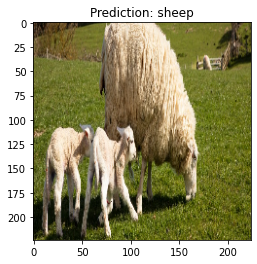

In [97]:
pred_and_plot(model,'/content/bed404f9-5a96-2c5c-8a6c-04023e554d88?t=1646155124804',class_names)

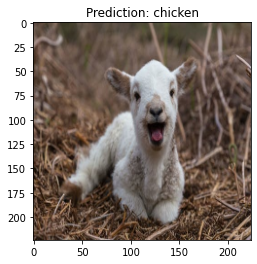

In [98]:
pred_and_plot(model,'/content/gallery-1487249462-happy-lamb.jpg?resize=480:*',class_names)

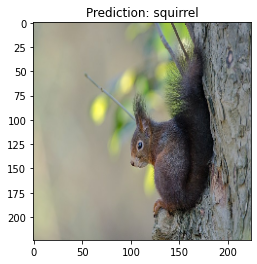

In [93]:
pred_and_plot(model,'/content/800px-European_Red_squirrel.jpg?20200516221351',class_names)

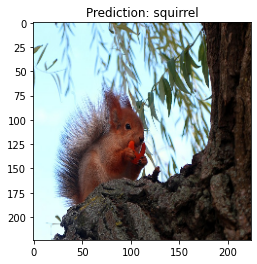

In [94]:
pred_and_plot(model,'/content/800px-SQuirrel.jpg?20171129214421',class_names)

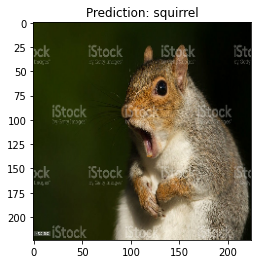

In [95]:
pred_and_plot(model,'/content/grey-squirrel-yawning-picture-id473012660?k=20',class_names)